In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
import os
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
import pylab
from sklearn.metrics import accuracy_score
from skimage.measure import regionprops
import itertools
from scipy.fft import fft
from scipy.spatial.distance import mahalanobis
from scipy.stats import chisquare

# Images

In [4]:

# Path to the folder containing images
base_folder = '/content/drive/MyDrive/mpeg7shapeB'


# Function to read binary shape masks from a folder and return an array along with filenames
def read_binary_masks(folder_path):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # You can add more image extensions if needed
            image_path = os.path.join(folder_path, filename)
            img = Image.open(image_path).convert('L')  # Convert to grayscale
            img_array = np.array(img)
            # Convert to binary (0 and 255) assuming white is the shape and black is the background
            img_array[img_array > 0] = 255
            images.append(img_array)
            filenames.append(filename)
    return np.array(images), filenames

# Read test images
test_folder = os.path.join(base_folder, 'test')
test_images, test_filenames = read_binary_masks(test_folder)

# Read train images
train_folder = os.path.join(base_folder, 'train')
train_images, train_filenames = read_binary_masks(train_folder)
# Display the shape of the arrays (number of images, height, width)
print("Test Images Shape:", test_images.shape)
print("Train Images Shape:", train_images.shape)

<ipython-input-4-e82633cc399f>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(images), filenames


Test Images Shape: (700,)
Train Images Shape: (700,)


Test Image 1 - Filename: bat-11.png, Shape: (743, 791)
Test Image 2 - Filename: apple-16.png, Shape: (256, 256)
Test Image 3 - Filename: apple-18.png, Shape: (256, 256)
Test Image 4 - Filename: bat-14.png, Shape: (464, 719)
Test Image 5 - Filename: bat-15.png, Shape: (819, 851)
Test Image 6 - Filename: apple-17.png, Shape: (256, 256)
Test Image 7 - Filename: bat-12.png, Shape: (216, 474)
Test Image 8 - Filename: apple-15.png, Shape: (256, 256)
Test Image 9 - Filename: apple-12.png, Shape: (256, 256)
Test Image 10 - Filename: apple-13.png, Shape: (256, 256)
Test Image 11 - Filename: apple-11.png, Shape: (256, 256)
Test Image 12 - Filename: apple-14.png, Shape: (256, 256)
Test Image 13 - Filename: bat-13.png, Shape: (472, 503)
Test Image 14 - Filename: apple-19.png, Shape: (256, 256)
Test Image 15 - Filename: apple-20.png, Shape: (256, 256)
Test Image 16 - Filename: bell-15.png, Shape: (303, 237)
Test Image 17 - Filename: bell-13.png, Shape: (253, 190)
Test Image 18 - Filename: bird-14.p

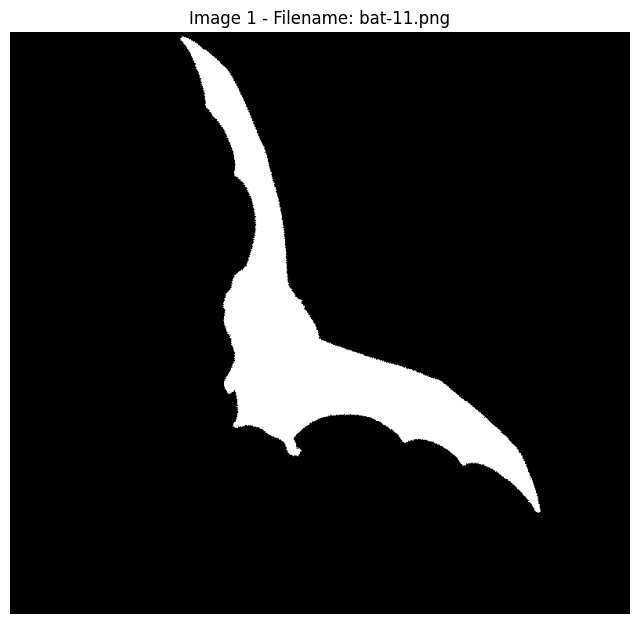

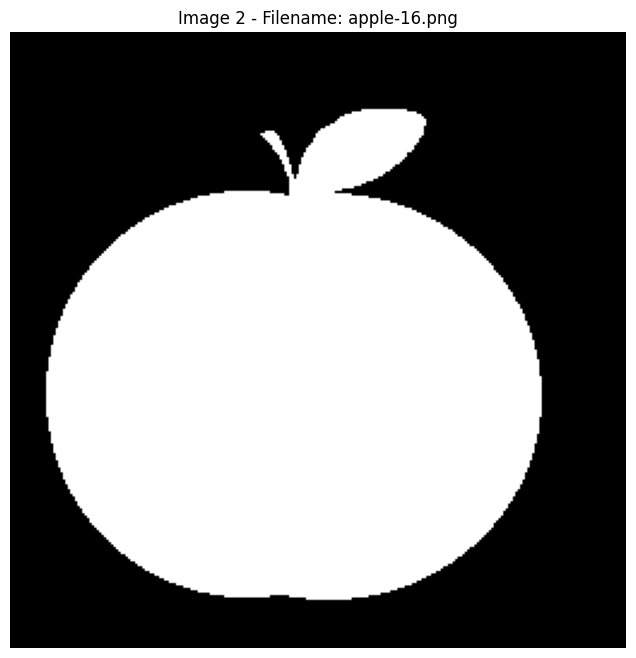

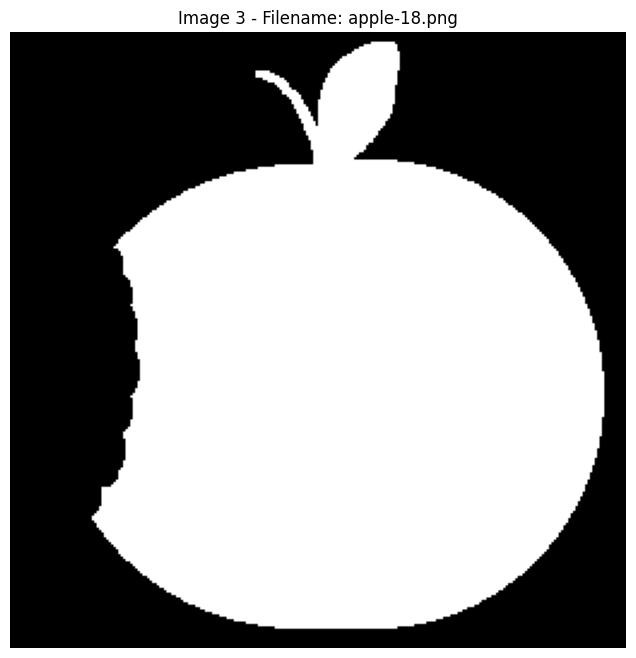

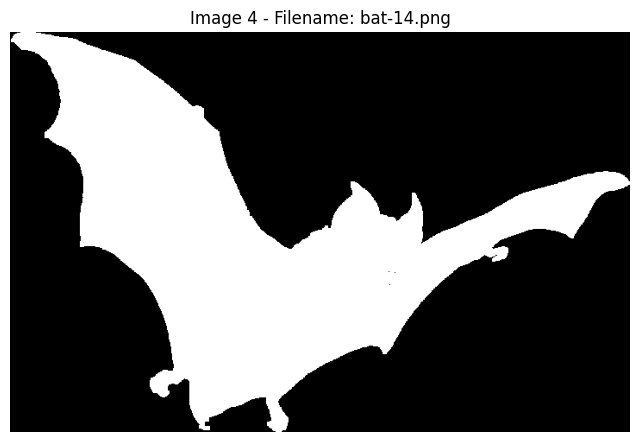

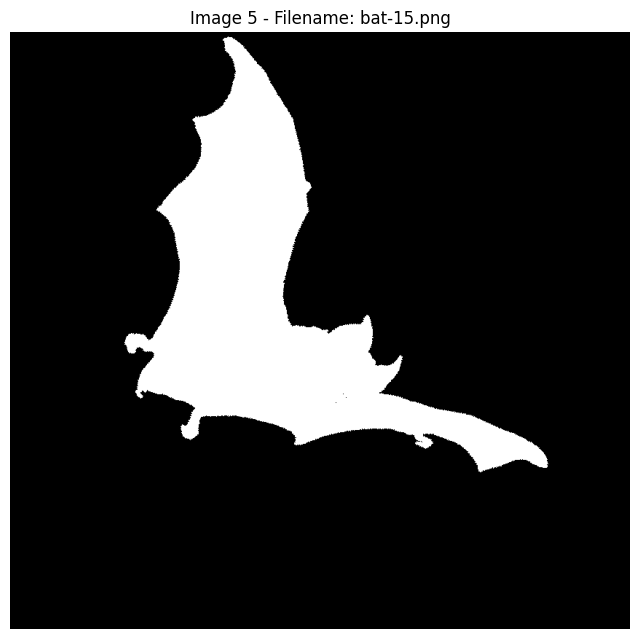

 Train Images:--------------------------------------------------


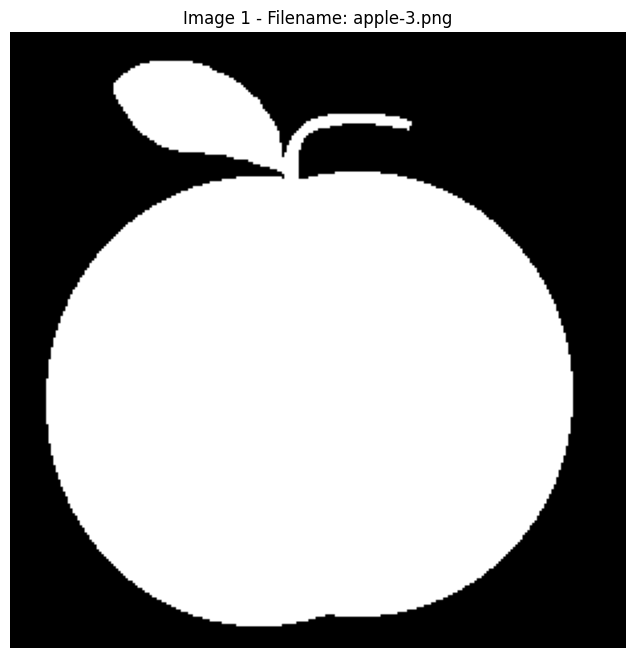

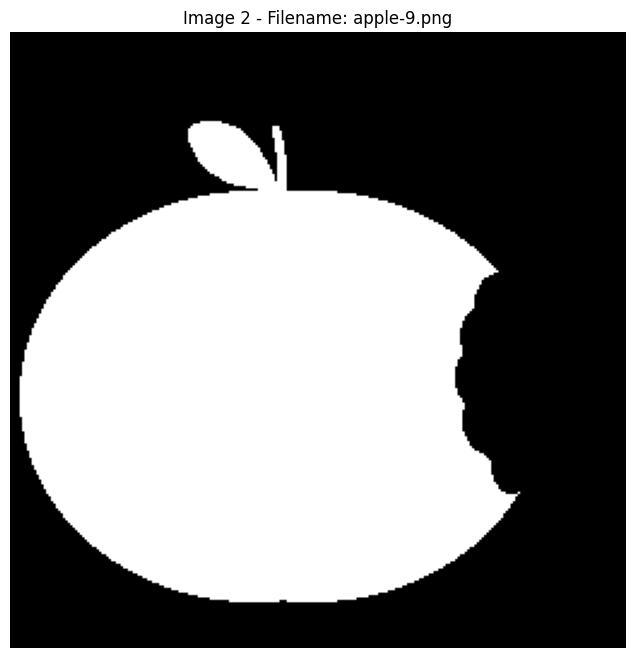

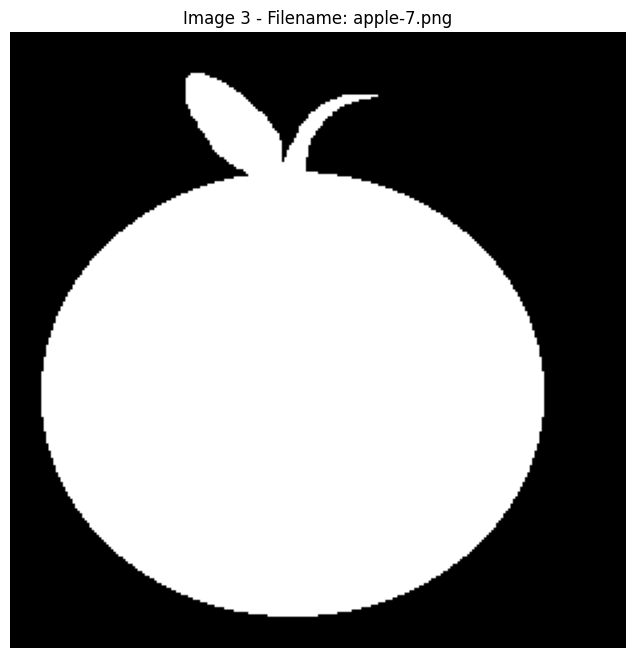

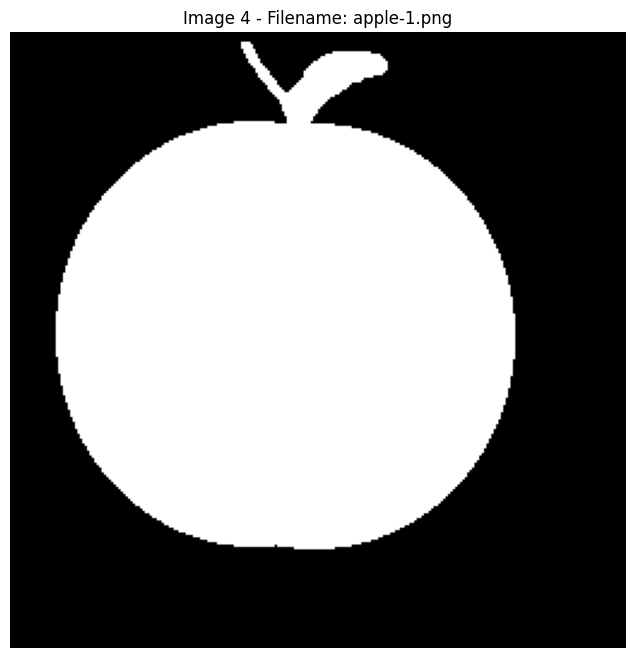

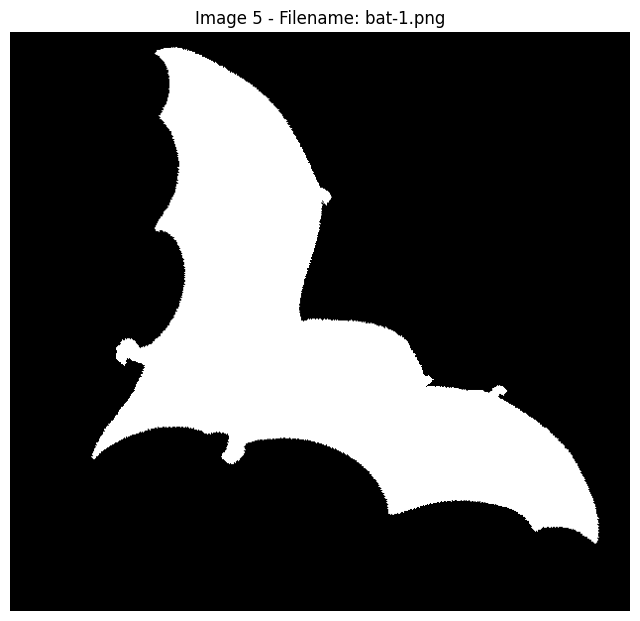

In [5]:
# Display the shape of the arrays (number of images, height, width) along with filenames
for i, filename in enumerate(test_filenames):
    print(f"Test Image {i+1} - Filename: {filename}, Shape: {test_images[i].shape}")

for i, filename in enumerate(train_filenames):
    print(f"Train Image {i+1} - Filename: {filename}, Shape: {train_images[i].shape}")
print("-"*50)
# Plot the first few images
def plot_images(images, filenames, num_images=5):
    for i in range(min(num_images, len(images))):
        plt.figure(figsize=(8, 8))
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Image {i+1} - Filename: {filenames[i]}")
        plt.axis('off')
        plt.show()
print(" Test Images:" + "-"*50)
# Plot the first 5 test images
plot_images(test_images, test_filenames, num_images=5)
print(" Train Images:" + "-"*50)
# Plot the first 5 train images
plot_images(train_images, train_filenames, num_images=5)

# Labels

In [6]:
# Extract true labels from filenames
def extract_labels_and_filenames(filenames):
    labels = [filename.split('-')[0] for filename in filenames]
    return labels

# Get true labels and filenames for test and train images
test_labels = extract_labels_and_filenames(test_filenames)
test_filenames_with_labels= list(zip(test_filenames, test_labels))

train_labels=extract_labels_and_filenames(train_filenames)
train_filenames_with_labels =  list(zip(train_filenames, train_labels))

# Display true labels and filenames for test images
print("Test Labels and Filenames:" + "-"*50)
for i, (filename, label) in enumerate(test_filenames_with_labels):
    print(f"Test Image {i+1} - Filename: {filename}, True Label: {label}")

# Display true labels and filenames for train images
print("Train Labels and Filenames:" + "-"*50)
for i, (filename, label) in enumerate(train_filenames_with_labels):
    print(f"Train Image {i+1} - Filename: {filename}, True Label: {label}")


Test Labels and Filenames:--------------------------------------------------
Test Image 1 - Filename: bat-11.png, True Label: bat
Test Image 2 - Filename: apple-16.png, True Label: apple
Test Image 3 - Filename: apple-18.png, True Label: apple
Test Image 4 - Filename: bat-14.png, True Label: bat
Test Image 5 - Filename: bat-15.png, True Label: bat
Test Image 6 - Filename: apple-17.png, True Label: apple
Test Image 7 - Filename: bat-12.png, True Label: bat
Test Image 8 - Filename: apple-15.png, True Label: apple
Test Image 9 - Filename: apple-12.png, True Label: apple
Test Image 10 - Filename: apple-13.png, True Label: apple
Test Image 11 - Filename: apple-11.png, True Label: apple
Test Image 12 - Filename: apple-14.png, True Label: apple
Test Image 13 - Filename: bat-13.png, True Label: bat
Test Image 14 - Filename: apple-19.png, True Label: apple
Test Image 15 - Filename: apple-20.png, True Label: apple
Test Image 16 - Filename: bell-15.png, True Label: bell
Test Image 17 - Filename: 


# *Basic Shape Descriptors*


In [ ]:

# Function to calculate all basic shape descriptors and convert to a feature vector
def calculate_basic_shape_descriptor(image):
    # Get region properties using regionprops
    props = regionprops(image.astype(int))

    # Calculate basic shape descriptors
    area = props[0].area
    perimeter = props[0].perimeter
    convexity = props[0].convex_area / area
    circularity = (4 * np.pi * area) / (perimeter**2)
    rectangularity = area / props[0].bbox_area
    eccentricity = props[0].eccentricity

    # Return a feature vector
    feature_vector = [area, perimeter, convexity, circularity, rectangularity, eccentricity]
    return feature_vector

# Calculate shape descriptors for test images
test_basic_shape_descriptor_feature_vectors = []
for image in test_images:
    feature_vector = calculate_basic_shape_descriptor(image)
    test_basic_shape_descriptor_feature_vectors.append(feature_vector)

# Calculate shape descriptors for train images
train_basic_shape_descriptor_feature_vectors = []
for image in train_images:
    feature_vector = calculate_basic_shape_descriptor(image)
    train_basic_shape_descriptor_feature_vectors.append(feature_vector)

# Display the feature vectors for the first few test images
for i, filename in enumerate(test_filenames[:5]):
    print(f"Test Image {i+1} - Filename: {filename}, Feature Vector: {test_basic_shape_descriptor_feature_vectors[i]}")

print("-"*50)
# Display the feature vectors for the first few test images

for i, filename in enumerate(train_filenames[:5]):
    print(f"Train Image {i+1} - Filename: {filename}, Feature Vector: {train_basic_shape_descriptor_feature_vectors[i]}")

Test Image 1 - Filename: bat-11.png, Feature Vector: [54152, 2237.3079707820734, 2.141933815925543, 0.13594800078263106, 0.19394026215887114, 0.9106012679575576]
Test Image 2 - Filename: apple-16.png, Feature Vector: [29956, 801.4234482783626, 1.0722726665776472, 0.5860971316344357, 0.7128307633733105, 0.389887427564839]
Test Image 3 - Filename: apple-18.png, Feature Vector: [34893, 899.3645737753169, 1.1309431691170149, 0.5420965224573434, 0.671380743477257, 0.3894359654315605]
Test Image 4 - Filename: bat-14.png, Feature Vector: [105251, 2664.792206135785, 1.7367815982746007, 0.18625562429876422, 0.3166072062424421, 0.8160355980074658]
Test Image 5 - Filename: bat-15.png, Feature Vector: [105251, 2965.731419060436, 1.7369906224168892, 0.15037389830391382, 0.3024141180797389, 0.8160496541006523]
--------------------------------------------------
Train Image 1 - Filename: apple-3.png, Feature Vector: [35986, 1005.891485709898, 1.1135719446451398, 0.4469317164638005, 0.6992324880987079,

**All Possible Combinations**

In [ ]:

# Function to calculate all possible combinations of basic shape descriptors and convert them into feature vectors for all test and train images
def calculate_all_combinations(images):
    all_feature_vectors = []
    all_descriptor_sets = []

    for image in images:
        # Calculate basic shape descriptors
        props = regionprops(image.astype(int))
        area = props[0].area
        perimeter = props[0].perimeter
        convexity = props[0].convex_area / area
        circularity = (4 * np.pi * area) / (perimeter**2)
        rectangularity = area / props[0].bbox_area
        eccentricity = props[0].eccentricity

        # Define the list of basic shape descriptors and their names
        descriptor_names = ["Area", "Perimeter", "Convexity", "Circularity", "Rectangularity", "Eccentricity"]
        descriptors = [area, perimeter, convexity, circularity, rectangularity, eccentricity]

        # Generate all non-empty combinations of descriptors
        all_combinations = []
        for r in range(1, len(descriptors) + 1):
            combinations = list(itertools.combinations(zip(descriptor_names, descriptors), r))
            all_combinations.extend(combinations)

        # Calculate feature vectors and corresponding descriptor names for each combination of one image
        feature_vectors = []
        descriptor_sets = []
        for combination in all_combinations:
            descriptor_set = [descriptor[0] for descriptor in combination]
            feature_vector = np.array([descriptor[1] for descriptor in combination])
            feature_vectors.append(feature_vector)
            descriptor_sets.append(descriptor_set)

        all_feature_vectors.append(feature_vectors)
        all_descriptor_sets.append(descriptor_sets)

    return all_feature_vectors, all_descriptor_sets


train_feature_vectors, train_descriptor_sets = calculate_all_combinations(train_images)
test_feature_vectors, test_descriptor_sets = calculate_all_combinations(test_images)

te_feature_vector=test_feature_vectors[0]
te_descriptor_set = test_descriptor_sets[0]

tr_feature_vector=train_feature_vectors[0]
tr_descriptor_set = train_descriptor_sets[0]

# Print the results
print("Test Set Example:\n")
print("-"*50)
for i, feature_vector in enumerate(te_feature_vector):
    print(f"Feature Vector {i + 1}: {feature_vector}, Descriptors: {te_descriptor_set[i]}")
print("-"*150)
print("Training Set Example:\n")
print("-"*50)
# Print the results
for i, feature_vector in enumerate(tr_feature_vector):
    print(f"Feature Vector {i + 1}: {feature_vector}, Descriptors: {tr_descriptor_set[i]}")



Test Set Example:

--------------------------------------------------
Feature Vector 1: [54152], Descriptors: ['Area']
Feature Vector 2: [2237.30797078], Descriptors: ['Perimeter']
Feature Vector 3: [2.14193382], Descriptors: ['Convexity']
Feature Vector 4: [0.135948], Descriptors: ['Circularity']
Feature Vector 5: [0.19394026], Descriptors: ['Rectangularity']
Feature Vector 6: [0.91060127], Descriptors: ['Eccentricity']
Feature Vector 7: [54152.          2237.30797078], Descriptors: ['Area', 'Perimeter']
Feature Vector 8: [5.41520000e+04 2.14193382e+00], Descriptors: ['Area', 'Convexity']
Feature Vector 9: [5.41520000e+04 1.35948001e-01], Descriptors: ['Area', 'Circularity']
Feature Vector 10: [5.41520000e+04 1.93940262e-01], Descriptors: ['Area', 'Rectangularity']
Feature Vector 11: [5.41520000e+04 9.10601268e-01], Descriptors: ['Area', 'Eccentricity']
Feature Vector 12: [2.23730797e+03 2.14193382e+00], Descriptors: ['Perimeter', 'Convexity']
Feature Vector 13: [2.23730797e+03 1.3594

# Fourier Descriptor


Test Image 1 - Filename: bat-11.png, Fourier Feature Vector: [30018805.01762976  5330676.90340503  3202920.13605777  2101994.51914226
  1656472.90448271  1189160.22939479  1011983.23206352   848846.06792823
   735630.76486181   712497.02989224]
Test Image 2 - Filename: apple-16.png, Fourier Feature Vector: [5622106.02250838  764726.59157024  432957.22025843  311602.84012283
  247298.63689013  206783.62104573  178082.08217724  156141.79974404
  138324.40905008  122862.23813463]
Test Image 3 - Filename: apple-18.png, Fourier Feature Vector: [7073443.85341808  881475.68279102  564489.64296857  403664.47070032
  299494.08656651  236523.72620459  208006.59963131  184351.93365001
  164825.58307091  152200.26834001]
Test Image 4 - Filename: bat-14.png, Fourier Feature Vector: [38986534.34967752  2377255.65500463  3751194.37315528  2963385.80941328
  1555406.71080204   983341.86663452   729410.91364741  1535574.36183254
  1081028.90621012   821919.46333665]
Test Image 5 - Filename: bat-15.png,

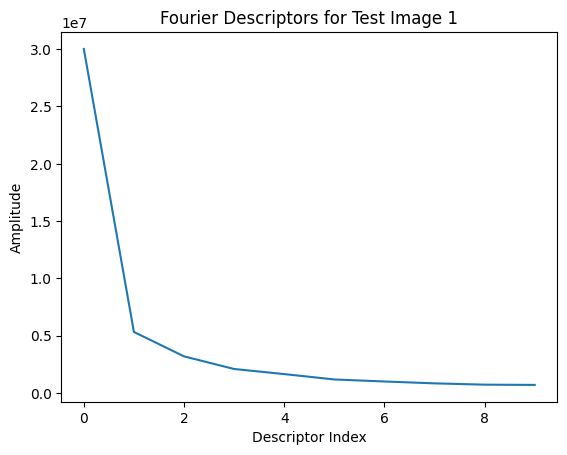

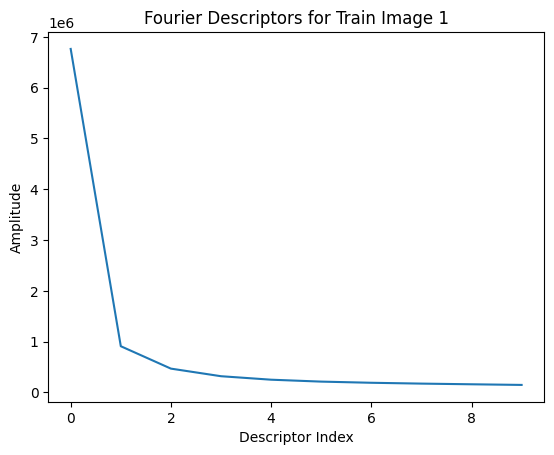

In [11]:

# Function to calculate Fourier descriptor of an image and convert to a feature vector
def calculate_fourier_descriptor(image, num_coefficients):
    # Get region properties using regionprops
    props = regionprops(image.astype(int))
    contour = props[0].coords

    # Calculate Fourier descriptors
    complex_contour = contour[:, 0] + 1j * contour[:, 1]
    fourier_coeffs = fft(complex_contour)

    # Keep only a subset of Fourier descriptors (the first num_descriptors)
    fourier_feature_vector = np.abs(fourier_coeffs[:num_coefficients])
    return fourier_feature_vector

# Calculate Fourier descriptor for test images
test_fourier_feature_vectors = []
for image in test_images:
    feature_vector = calculate_fourier_descriptor(image,10)
    test_fourier_feature_vectors.append(feature_vector)

# Calculate Fourier descriptor for train images
train_fourier_feature_vectors = []
for image in train_images:
    feature_vector = calculate_fourier_descriptor(image,10)
    train_fourier_feature_vectors.append(feature_vector)

# Display the Fourier feature vectors for the first few test images
for i, filename in enumerate(test_filenames[:5]):
    print(f"Test Image {i+1} - Filename: {filename}, Fourier Feature Vector: {test_fourier_feature_vectors[i]}")
print("-"*50)
# Display the Fourier feature vectors for the first few train images
for i, filename in enumerate(train_filenames[:5]):
    print(f"Train Image {i+1} - Filename: {filename}, Fourier Feature Vector: {train_fourier_feature_vectors[i]}")

# Plot the first few Fourier descriptors for the first test image
plt.plot(np.abs(test_fourier_feature_vectors[0]))
plt.title("Fourier Descriptors for Test Image 1")
plt.xlabel("Descriptor Index")
plt.ylabel("Amplitude")
plt.show()
# Plot the first few Fourier descriptors for the first test image
plt.plot(np.abs(train_fourier_feature_vectors[0]))
plt.title("Fourier Descriptors for Train Image 1")
plt.xlabel("Descriptor Index")
plt.ylabel("Amplitude")
plt.show()

**A Few Possible Variations**

In [7]:
coefficients_to_test = [5, 20, 50, 70 ]

def resize_feature_vectors(feature_vectors, min_size):
    # Resize all feature vectors to the minimum size
    return [vector[:min_size] for vector in feature_vectors]

# Function to calculate Fourier descriptor with few possible diffrent coefficients for all test and train images and convert them into feature vectors
def test_fourier_coefficients(coefficients, train_images, test_images,train_filenames,test_filenames):

    all_test_feature_vectors=[]
    all_train_feature_vectors=[]
    all_min_sizes = []

    for num_coefficient in coefficients:

        min_size_test = float('inf')
        min_size_train = float('inf')

        test_fourier_feature_vectors = []
        for image in test_images:
            feature_vector = calculate_fourier_descriptor(image,num_coefficient)
            test_fourier_feature_vectors.append(feature_vector)
            # Update min_size_test if the current feature_vector size is smaller
            min_size_test = min(min_size_test, len(feature_vector))

        train_fourier_feature_vectors = []
        for image in train_images:
            feature_vector = calculate_fourier_descriptor(image,num_coefficient)
            train_fourier_feature_vectors.append(feature_vector)
            # Update min_size_train if the current feature_vector size is smaller
            min_size_train = min(min_size_train, len(feature_vector))

        # Find the global minimum size across test and train feature vectors
        min_size = min(min_size_test, min_size_train)
        # Resize feature vectors to the minimum size
        test_fourier_feature_vectors_resized = resize_feature_vectors(test_fourier_feature_vectors, min_size)
        train_fourier_feature_vectors_resized = resize_feature_vectors(train_fourier_feature_vectors, min_size)

        # Store the minimum size in the array
        all_min_sizes.append(min_size)
        # Store the feature vectors with num_coefficient for all test and train images
        all_test_feature_vectors.append(test_fourier_feature_vectors_resized)
        all_train_feature_vectors.append(train_fourier_feature_vectors_resized)

        print("-"*150)
        print(f"Testing with {min_size} coefficient:")
        print("-"*150)

        # Display the Fourier feature vectors for the first few test images
        for i, filename in enumerate(test_filenames[:5]):
            print(f"Test Image {i+1} - Filename: {filename}, Fourier Feature Vector: {test_fourier_feature_vectors_resized[i]}")
        print("-"*150)
        # Display the Fourier feature vectors for the first few train images
        for i, filename in enumerate(train_filenames[:5]):
            print(f"Train Image {i+1} - Filename: {filename}, Fourier Feature Vector: {train_fourier_feature_vectors_resized[i]}")

    return all_test_feature_vectors,all_train_feature_vectors,all_min_sizes


all_fourier_coefficents_test_feature_vectors, all_fourier_coefficents_train_feature_vectors,num_coefficients_to_test = test_fourier_coefficients(coefficients_to_test,train_images,test_images,train_filenames,test_filenames)







------------------------------------------------------------------------------------------------------------------------------------------------------
Testing with 5 coefficient:
------------------------------------------------------------------------------------------------------------------------------------------------------
Test Image 1 - Filename: bat-11.png, Fourier Feature Vector: [30018805.01762976  5330676.90340503  3202920.13605777  2101994.51914226
  1656472.90448271]
Test Image 2 - Filename: apple-16.png, Fourier Feature Vector: [5622106.02250838  764726.59157024  432957.22025843  311602.84012283
  247298.63689013]
Test Image 3 - Filename: apple-18.png, Fourier Feature Vector: [7073443.85341808  881475.68279102  564489.64296857  403664.47070032
  299494.08656651]
Test Image 4 - Filename: bat-14.png, Fourier Feature Vector: [38986534.34967752  2377255.65500463  3751194.37315528  2963385.80941328
  1555406.71080204]
Test Image 5 - Filename: bat-15.png, Fourier Feature Vector:

# Shape Histogram Descriptor

In [8]:

# Function to calculate shape histogram as a shape descriptor and return feature vector for an image
def calculate_shape_histogram(image, num_bins):
    # Get region properties using regionprops
    props = regionprops(image.astype(int))
    center_of_mass = props[0].centroid

    # Calculate distance from each pixel to the center of mass
    y, x = np.where(image > 0)
    distances = np.sqrt((x - center_of_mass[1])**2 + (y - center_of_mass[0])**2)

    # Determine the maximum distance from the center
    max_distance = int(np.max(distances))

   # Create concentric circles and calculate areas
    bins = np.arange(num_bins + 1) * (max_distance / num_bins)
    histogram = np.zeros(num_bins)

    for i in range(num_bins):
        inner_radius = int(bins[i])
        outer_radius = int(bins[i + 1]) if i < num_bins - 1 else max_distance
        circle_mask = np.zeros_like(image, dtype=np.uint8)

        # Create circular mask using OpenCV
        cv2.circle(circle_mask, (int(center_of_mass[1]), int(center_of_mass[0])), outer_radius, 255, thickness=cv2.FILLED)
        cv2.circle(circle_mask, (int(center_of_mass[1]), int(center_of_mass[0])), inner_radius, 0, thickness=cv2.FILLED)

        # Calculate area by counting pixels
        area = np.sum(np.logical_and(circle_mask > 0, image > 0))
        histogram[i] = area

    # Normalize by the total surface
    total_surface = np.sum(image > 0)
    normalized_histogram = histogram / total_surface

    return normalized_histogram

# Calculate shape histogram for test images
test_shape_histograms = []
for image in test_images:
    histogram = calculate_shape_histogram(image,5)
    test_shape_histograms.append(histogram)

# Calculate shape histogram for test images
train_shape_histograms = []
for image in train_images:
    histogram = calculate_shape_histogram(image,5)
    train_shape_histograms.append(histogram)

# Display the shape histogram for the first few test images
for i, filename in enumerate(test_filenames[:5]):
    print(f"Test Image {i+1} - Filename: {filename}, Shape Histogram: {test_shape_histograms[i]}")

print("-"*50)
# Display the shape histogram for the first few test images
for i, filename in enumerate(train_filenames[:5]):
    print(f"Train Image {i+1} - Filename: {filename}, Shape Histogram: {train_shape_histograms[i]}")

Test Image 1 - Filename: bat-11.png, Shape Histogram: [0.23001921 0.43771237 0.16654971 0.11994017 0.04577855]
Test Image 2 - Filename: apple-16.png, Shape Histogram: [0.05982107 0.19134731 0.30725063 0.37835492 0.06319268]
Test Image 3 - Filename: apple-18.png, Shape Histogram: [0.07027197 0.22170636 0.35858195 0.31954833 0.02986272]
Test Image 4 - Filename: bat-14.png, Shape Histogram: [0.16487254 0.46464167 0.25316624 0.08254553 0.03472651]
Test Image 5 - Filename: bat-15.png, Shape Histogram: [0.16637372 0.46418561 0.25178858 0.08242202 0.03517306]
--------------------------------------------------
Train Image 1 - Filename: apple-3.png, Shape Histogram: [0.0730284  0.2203079  0.37928639 0.29519813 0.03215139]
Train Image 2 - Filename: apple-9.png, Shape Histogram: [0.05292742 0.16911636 0.28432776 0.37073631 0.12264777]
Train Image 3 - Filename: apple-7.png, Shape Histogram: [0.06686432 0.21093799 0.35551631 0.34444585 0.02214092]
Train Image 4 - Filename: apple-1.png, Shape Histog

**A Few Possible Variations**

In [ ]:
num_lengths_to_test = [5, 10, 20, 30]

# Function to calculate shape histogram descriptor with few possible diffrent lengths for all test and train images and convert them into feature vectors
def test_shape_histogram_lengths(lengths, train_images, test_images,train_filenames,test_filenames):

    all_test_feature_vectors=[]
    all_train_feature_vectors=[]

    for num_length in lengths:
        print("-"*150)
        print(f"Testing with {num_length} Length:")
        print("-"*150)

        # Calculate shape histograms for test images
        test_shape_histograms = []
        for image in test_images:
          histogram = calculate_shape_histogram(image,num_length)
          test_shape_histograms.append(histogram)

        # Calculate shape histograms for train images
        train_shape_histograms = []
        for image in train_images:
          histogram = calculate_shape_histogram(image,num_length)
          train_shape_histograms.append(histogram)

        all_test_feature_vectors.append(test_shape_histograms)
        all_train_feature_vectors.append(train_shape_histograms)

        # Display the shape histograms for the first few test images
        for i, filename in enumerate(test_filenames[:5]):
            print(f"Test Image {i+1} - Filename: {filename}, Shape Histogram: {test_shape_histograms[i]}")

        print("-"*150)
        # Display the shape histograms for the first few test images
        for i, filename in enumerate(train_filenames[:5]):
            print(f"Train Image {i+1} - Filename: {filename}, Shape Histogram: {train_shape_histograms[i]}")

    return all_test_feature_vectors,all_train_feature_vectors


all_shape_histogram_lengths_test_feature_vectors, all_shape_histogram_lengths_train_feature_vectors = test_shape_histogram_lengths(num_lengths_to_test,train_images,test_images,train_filenames,test_filenames)







------------------------------------------------------------------------------------------------------------------------------------------------------
Testing with 5 Length:
------------------------------------------------------------------------------------------------------------------------------------------------------
Test Image 1 - Filename: bat-11.png, Shape Histogram: [0.23001921 0.43771237 0.16654971 0.11994017 0.04577855]
Test Image 2 - Filename: apple-16.png, Shape Histogram: [0.05982107 0.19134731 0.30725063 0.37835492 0.06319268]
Test Image 3 - Filename: apple-18.png, Shape Histogram: [0.07027197 0.22170636 0.35858195 0.31954833 0.02986272]
Test Image 4 - Filename: bat-14.png, Shape Histogram: [0.16487254 0.46464167 0.25316624 0.08254553 0.03472651]
Test Image 5 - Filename: bat-15.png, Shape Histogram: [0.16637372 0.46418561 0.25178858 0.08242202 0.03517306]
--------------------------------------------------------------------------------------------------------------------

# Moment Invariant Descriptors

In [ ]:

# Function to calculate all moment invariant descriptors and convert to a feature vector for an image
def calculate_moment_invariants(image):
    # Find contours from the binary image
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Use the first (largest) contour
    contour = contours[0]

    # Calculate moments
    moments = cv2.moments(contour)

    # Calculate Hu's moment invariants
    hu_moments = cv2.HuMoments(moments).flatten()

    return hu_moments



# Calculate moment invariants for test images
test_moment_invariants = []
for image in test_images:
    moment_invariants = calculate_moment_invariants(image)
    test_moment_invariants.append(moment_invariants)


# Calculate moment invariants for train images
train_moment_invariants = []
for image in train_images:
    moment_invariants = calculate_moment_invariants(image)
    train_moment_invariants.append(moment_invariants)


# Display the moment invariants for the first few test images
for i, filename in enumerate(test_filenames[:5]):
    print(f"Test Image {i+1} - Filename: {filename}, Moment Invariants: {test_moment_invariants[i]}")

print("-"*50)
# Display the moment invariants for the first few test images
for i, filename in enumerate(train_filenames[:5]):
    print(f"Train Image {i+1} - Filename: {filename}, Moment Invariants: {train_moment_invariants[i]}")

Test Image 1 - Filename: bat-11.png, Moment Invariants: [ 0.57048592  0.16273698  0.18742202  0.03432593  0.00135694  0.0006809
 -0.00239563]
Test Image 2 - Filename: apple-16.png, Moment Invariants: [ 1.64076375e-01  1.97276339e-04  1.03892474e-04  3.56219991e-06
  6.83833074e-11 -3.36946258e-08  4.45429984e-12]
Test Image 3 - Filename: apple-18.png, Moment Invariants: [1.65765660e-01 1.70307124e-04 1.95480012e-04 7.94013176e-06
 2.77684946e-10 5.97436076e-08 1.44036890e-10]
Test Image 4 - Filename: bat-14.png, Moment Invariants: [ 3.16082759e-01  2.50038042e-02  2.85893563e-02  3.82946082e-03
  4.75255240e-06 -2.68294935e-04  3.97861656e-05]
Test Image 5 - Filename: bat-15.png, Moment Invariants: [ 3.16260201e-01  2.50262881e-02  2.86621534e-02  3.84140356e-03
  4.79791313e-06 -2.69259153e-04  4.00212490e-05]
--------------------------------------------------
Train Image 1 - Filename: apple-3.png, Moment Invariants: [ 1.68282679e-01  1.49068382e-04  2.84806715e-04  2.49453690e-05
  2

**All Possible Combinations**

In [ ]:
# Function to calculate all possible combinations of moment invariant descriptors and convert them into feature vectors for all test and train images
def calculate_all_combinations_moment(images):
    all_feature_vectors = []
    all_moment_sets = []

    for image in images:
      #Find contours from the binary image
      contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

      # Use the first (largest) contour
      contour = contours[0]

      # Calculate moments
      moments = cv2.moments(contour)

      # Calculate Hu's moment invariants
      hu_moments = cv2.HuMoments(moments).flatten()

      # Define the list of basic shape descriptors and their names
      moments_names = ["I1", "I2", "I3", "I4", "I5", "I6", "I7"]


      # Generate all non-empty combinations of descriptors
      all_combinations = []
      for r in range(1, len(moments_names) + 1):
          combinations = list(itertools.combinations(zip(moments_names, hu_moments), r))
          all_combinations.extend(combinations)

      # Calculate feature vectors and corresponding descriptor names for each combination of one image
      feature_vectors = []
      moments_sets = []
      for combination in all_combinations:
        moments_set = [moments[0] for moments in combination]
        feature_vector = np.array([moments[1] for moments in combination])
        feature_vectors.append(feature_vector)
        moments_sets.append(moments_set)

      all_feature_vectors.append(feature_vectors)
      all_moment_sets.append(moments_sets)

    return all_feature_vectors, all_moment_sets


train_feature_vectors_moments, train_moment_sets = calculate_all_combinations_moment(train_images)
test_feature_vectors_moments, test_moment_sets = calculate_all_combinations_moment(test_images)

te_feature_vector_moment=test_feature_vectors_moments[0]
te_moment_set = test_moment_sets[0]

tr_feature_vector_moment=train_feature_vectors_moments[0]
tr_moment_set = train_moment_sets[0]

# Print the results
print("Test Set Example:\n")
print("-"*50)
for i, feature_vector in enumerate(te_feature_vector_moment):
    print(f"Feature Vector {i + 1}: {feature_vector}, Descriptors: {te_moment_set[i]}")
print("-"*150)
print("Training Set Example:\n")
print("-"*50)
# Print the results
for i, feature_vector in enumerate(tr_feature_vector_moment):
    print(f"Feature Vector {i + 1}: {feature_vector}, Descriptors: {tr_moment_set[i]}")



Test Set Example:

--------------------------------------------------
Feature Vector 1: [0.57048592], Descriptors: ['I1']
Feature Vector 2: [0.16273698], Descriptors: ['I2']
Feature Vector 3: [0.18742202], Descriptors: ['I3']
Feature Vector 4: [0.03432593], Descriptors: ['I4']
Feature Vector 5: [0.00135694], Descriptors: ['I5']
Feature Vector 6: [0.0006809], Descriptors: ['I6']
Feature Vector 7: [-0.00239563], Descriptors: ['I7']
Feature Vector 8: [0.57048592 0.16273698], Descriptors: ['I1', 'I2']
Feature Vector 9: [0.57048592 0.18742202], Descriptors: ['I1', 'I3']
Feature Vector 10: [0.57048592 0.03432593], Descriptors: ['I1', 'I4']
Feature Vector 11: [0.57048592 0.00135694], Descriptors: ['I1', 'I5']
Feature Vector 12: [0.57048592 0.0006809 ], Descriptors: ['I1', 'I6']
Feature Vector 13: [ 0.57048592 -0.00239563], Descriptors: ['I1', 'I7']
Feature Vector 14: [0.16273698 0.18742202], Descriptors: ['I2', 'I3']
Feature Vector 15: [0.16273698 0.03432593], Descriptors: ['I2', 'I4']
Featur

# Distance Metrics

In [1]:

def euclidean_distance(vector_A, vector_B):
  return np.linalg.norm(np.array(vector_A) - np.array(vector_B))


def manhattan_distance(vector_A, vector_B):
  return np.sum(np.abs(np.array(vector_A) - np.array(vector_B)))

def chi_squared_distance(vector_A, vector_B):
  return np.sum((np.array(vector_A) - np.array(vector_B))**2 / (np.array(vector_A) + np.array(vector_B)+ 1e-10))

def mahalanobis_distance(vector_A, vector_B, regularization_param=1e-5):

    data_matrix = np.vstack((vector_A, vector_B))
    cov_matrix = np.cov(data_matrix, rowvar=False)
    regularized_cov_matrix = cov_matrix + np.eye(cov_matrix.shape[0]) * regularization_param
    inverse_covariance_matrix = np.linalg.pinv(regularized_cov_matrix)
    distance = mahalanobis(vector_A, vector_B, inverse_covariance_matrix)
    return distance




# Model for Basic Shape Descriptors

In [ ]:

# Initialize variables to track the average accuracies for each distance metric
average_accuracy_euclidean = 0
average_accuracy_manhattan = 0
average_accuracy_chi_squared = 0
average_accuracy_mahalanobis = 0

best_accuracy = 0
best_distance = ""
best_descriptor_set = []

 #Iterate over combinations of feature vectors for the first set of descriptors
for i,  descriptor_set in enumerate(test_descriptor_sets[0]):
    print(f"\nExperiment {i+1} with Test Descriptor Set: {descriptor_set}\n" + "-"*80)

    # Initialize lists to store predictions for each distance metric
    predictions_euclidean = []
    predictions_manhattan = []
    predictions_chi_squared = []
    predictions_mahalanobis = []

    # Iterate over test images and their corresponding feature vectors
    for te_image in test_feature_vectors:
        # Initialize lists to store distances for each distance metric
        distances_euclidean = []
        distances_manhattan = []
        distances_chi_squared = []
        distances_mahalanobis = []

        test_vector=te_image[i]

        # Iterate over training images and their corresponding feature vectors
        for tr_image in train_feature_vectors:
            train_vector=tr_image[i]
            # Calculate distances for each distance metric
            distances_euclidean.append(euclidean_distance(train_vector, test_vector))
            distances_manhattan.append(manhattan_distance(train_vector, test_vector))
            distances_chi_squared.append(chi_squared_distance(train_vector, test_vector))
            distances_mahalanobis.append(mahalanobis_distance(train_vector, test_vector))

        # Find the index of the minimum distance for each distance metric
        closest_index_euclidean = np.argmin(distances_euclidean)
        closest_index_manhattan = np.argmin(distances_manhattan)
        closest_index_chi_squared = np.argmin(distances_chi_squared)
        closest_index_mahalanobis = np.argmin(distances_mahalanobis)

        # Predicted class for each distance metric
        predicted_class_euclidean = train_labels[closest_index_euclidean]
        predicted_class_manhattan = train_labels[closest_index_manhattan]
        predicted_class_chi_squared = train_labels[closest_index_chi_squared]
        predicted_class_mahalanobis = train_labels[closest_index_mahalanobis]

        # Append predictions to lists
        predictions_euclidean.append(predicted_class_euclidean)
        predictions_manhattan.append(predicted_class_manhattan)
        predictions_chi_squared.append(predicted_class_chi_squared)
        predictions_mahalanobis.append(predicted_class_mahalanobis)

    # Calculate accuracy for each distance metric
    accuracy_euclidean = accuracy_score(test_labels, predictions_euclidean)
    accuracy_manhattan = accuracy_score(test_labels, predictions_manhattan)
    accuracy_chi_squared = accuracy_score(test_labels, predictions_chi_squared)
    accuracy_mahalanobis = accuracy_score(test_labels, predictions_mahalanobis)

    # Print results for each distance metric
    print(f"Accuracy (Euclidean Distance): {accuracy_euclidean}")
    print(f"Accuracy (Manhattan Distance): {accuracy_manhattan}")
    print(f"Accuracy (Chi-squared Distance): {accuracy_chi_squared}")
    print(f"Accuracy (Mahalanobis Distance): {accuracy_mahalanobis}")
    print("-"*80)

    # Accumulate average accuracies
    average_accuracy_euclidean += accuracy_euclidean
    average_accuracy_manhattan += accuracy_manhattan
    average_accuracy_chi_squared += accuracy_chi_squared
    average_accuracy_mahalanobis += accuracy_mahalanobis

    # Update the best accuracy, corresponding distance, and descriptor set if a higher accuracy is encountered
    if accuracy_euclidean > best_accuracy:
        best_accuracy = accuracy_euclidean
        best_distance = "Euclidean Distance"
        best_descriptor_set = descriptor_set

    if accuracy_manhattan > best_accuracy:
        best_accuracy = accuracy_manhattan
        best_distance = "Manhattan Distance"
        best_descriptor_set = descriptor_set

    if accuracy_chi_squared > best_accuracy:
        best_accuracy = accuracy_chi_squared
        best_distance = "Chi-squared Distance"
        best_descriptor_set = descriptor_set

    if accuracy_mahalanobis > best_accuracy:
        best_accuracy = accuracy_mahalanobis
        best_distance = "Mahalanobis Distance"
        best_descriptor_set = descriptor_set

# Calculate overall average accuracies
num_experiments = len(test_descriptor_sets[0])
average_accuracy_euclidean /= num_experiments
average_accuracy_manhattan /= num_experiments
average_accuracy_chi_squared /= num_experiments
average_accuracy_mahalanobis /= num_experiments

print("-"*150)
# Print the average accuracies and the best accuracy with corresponding distance
print("\nAverage Accuracies:")
print(f"Average Accuracy (Euclidean Distance): {average_accuracy_euclidean}")
print(f"Average Accuracy (Manhattan Distance): {average_accuracy_manhattan}")
print(f"Average Accuracy (Chi-squared Distance): {average_accuracy_chi_squared}")
print(f"Average Accuracy (Mahalanobis Distance): {average_accuracy_mahalanobis}")

# Print the best accuracy, corresponding distance, and descriptor set
print("\nBest Accuracy:")
print(f"Best Accuracy: {best_accuracy}")
print(f"Best Distance: {best_distance}")
print(f"Best Descriptor Set: {best_descriptor_set}")



Experiment 1 with Test Descriptor Set: ['Area']
--------------------------------------------------------------------------------
Accuracy (Euclidean Distance): 0.18428571428571427
Accuracy (Manhattan Distance): 0.18428571428571427
Accuracy (Chi-squared Distance): 0.18428571428571427
Accuracy (Mahalanobis Distance): 0.18428571428571427
--------------------------------------------------------------------------------

Experiment 2 with Test Descriptor Set: ['Perimeter']
--------------------------------------------------------------------------------
Accuracy (Euclidean Distance): 0.14
Accuracy (Manhattan Distance): 0.14
Accuracy (Chi-squared Distance): 0.14
Accuracy (Mahalanobis Distance): 0.14
--------------------------------------------------------------------------------

Experiment 3 with Test Descriptor Set: ['Convexity']
--------------------------------------------------------------------------------
Accuracy (Euclidean Distance): 0.13142857142857142
Accuracy (Manhattan Distance): 

# Model for Fourier Descriptors

In [13]:
# Initialize variables to track the average accuracies for each distance metric
average_accuracy_euclidean = 0
average_accuracy_manhattan = 0
average_accuracy_chi_squared = 0
average_accuracy_mahalanobis = 0

best_accuracy = 0
best_distance = ""
best_coefficient = ""

 #Iterate over combinations of feature vectors for the first set of descriptors
for i,  coefficient in enumerate(num_coefficients_to_test):
    print(f"\nExperiment {i+1} with Coefficient: {coefficient}\n" + "-"*80)

    # Initialize lists to store predictions for each distance metric
    predictions_euclidean = []
    predictions_manhattan = []
    predictions_chi_squared = []
    predictions_mahalanobis = []

    # Iterate over test images and their corresponding feature vectors
    for test_vector in all_fourier_coefficents_test_feature_vectors[i]:
        # Initialize lists to store distances for each distance metric
        distances_euclidean = []
        distances_manhattan = []
        distances_chi_squared = []
        distances_mahalanobis = []


        # Iterate over training images and their corresponding feature vectors
        for train_vector in all_fourier_coefficents_train_feature_vectors[i]:

            # Calculate distances for each distance metric
            distances_euclidean.append(euclidean_distance(train_vector, test_vector))
            distances_manhattan.append(manhattan_distance(train_vector, test_vector))
            distances_chi_squared.append(chi_squared_distance(train_vector, test_vector))
            distances_mahalanobis.append(mahalanobis_distance(train_vector, test_vector))

        # Find the index of the minimum distance for each distance metric
        closest_index_euclidean = np.argmin(distances_euclidean)
        closest_index_manhattan = np.argmin(distances_manhattan)
        closest_index_chi_squared = np.argmin(distances_chi_squared)
        closest_index_mahalanobis = np.argmin(distances_mahalanobis)

        # Predicted class for each distance metric
        predicted_class_euclidean = train_labels[closest_index_euclidean]
        predicted_class_manhattan = train_labels[closest_index_manhattan]
        predicted_class_chi_squared = train_labels[closest_index_chi_squared]
        predicted_class_mahalanobis = train_labels[closest_index_mahalanobis]

        # Append predictions to lists
        predictions_euclidean.append(predicted_class_euclidean)
        predictions_manhattan.append(predicted_class_manhattan)
        predictions_chi_squared.append(predicted_class_chi_squared)
        predictions_mahalanobis.append(predicted_class_mahalanobis)

    # Calculate accuracy for each distance metric
    accuracy_euclidean = accuracy_score(test_labels, predictions_euclidean)
    accuracy_manhattan = accuracy_score(test_labels, predictions_manhattan)
    accuracy_chi_squared = accuracy_score(test_labels, predictions_chi_squared)
    accuracy_mahalanobis = accuracy_score(test_labels, predictions_mahalanobis)

    # Print results for each distance metric
    print(f"Accuracy (Euclidean Distance): {accuracy_euclidean}")
    print(f"Accuracy (Manhattan Distance): {accuracy_manhattan}")
    print(f"Accuracy (Chi-squared Distance): {accuracy_chi_squared}")
    print(f"Accuracy (Mahalanobis Distance): {accuracy_mahalanobis}")
    print("-"*80)

    # Accumulate average accuracies
    average_accuracy_euclidean += accuracy_euclidean
    average_accuracy_manhattan += accuracy_manhattan
    average_accuracy_chi_squared += accuracy_chi_squared
    average_accuracy_mahalanobis += accuracy_mahalanobis

    # Update the best accuracy, corresponding distance, and descriptor set if a higher accuracy is encountered
    if accuracy_euclidean > best_accuracy:
        best_accuracy = accuracy_euclidean
        best_distance = "Euclidean Distance"
        best_coefficient = str(coefficient)

    if accuracy_manhattan > best_accuracy:
        best_accuracy = accuracy_manhattan
        best_distance = "Manhattan Distance"
        best_coefficient = str(coefficient)

    if accuracy_chi_squared > best_accuracy:
        best_accuracy = accuracy_chi_squared
        best_distance = "Chi-squared Distance"
        best_coefficient = str(coefficient)

    if accuracy_mahalanobis > best_accuracy:
        best_accuracy = accuracy_mahalanobis
        best_distance = "Mahalanobis Distance"
        best_coefficient = str(coefficient)

# Calculate overall average accuracies
num_experiments = len(num_coefficients_to_test)
average_accuracy_euclidean /= num_experiments
average_accuracy_manhattan /= num_experiments
average_accuracy_chi_squared /= num_experiments
average_accuracy_mahalanobis /= num_experiments

print("-"*150)
# Print the average accuracies and the best accuracy with corresponding distance
print("\nAverage Accuracies:")
print(f"Average Accuracy (Euclidean Distance): {average_accuracy_euclidean}")
print(f"Average Accuracy (Manhattan Distance): {average_accuracy_manhattan}")
print(f"Average Accuracy (Chi-squared Distance): {average_accuracy_chi_squared}")
print(f"Average Accuracy (Mahalanobis Distance): {average_accuracy_mahalanobis}")

# Print the best accuracy, corresponding distance, and descriptor set
print("\nBest Accuracy:")
print(f"Best Accuracy: {best_accuracy}")
print(f"Best Distance: {best_distance}")
print(f"Best Coefficient: {best_coefficient}")



Experiment 1 with Coefficient: 5
--------------------------------------------------------------------------------
Accuracy (Euclidean Distance): 0.3442857142857143
Accuracy (Manhattan Distance): 0.3585714285714286
Accuracy (Chi-squared Distance): 0.4085714285714286
Accuracy (Mahalanobis Distance): 0.09714285714285714
--------------------------------------------------------------------------------

Experiment 2 with Coefficient: 20
--------------------------------------------------------------------------------
Accuracy (Euclidean Distance): 0.35714285714285715
Accuracy (Manhattan Distance): 0.3942857142857143
Accuracy (Chi-squared Distance): 0.4142857142857143
Accuracy (Mahalanobis Distance): 0.09571428571428571
--------------------------------------------------------------------------------

Experiment 3 with Coefficient: 50
--------------------------------------------------------------------------------
Accuracy (Euclidean Distance): 0.35714285714285715
Accuracy (Manhattan Distance)

# Model for Shape Histograms Descriptors

In [ ]:

# Initialize variables to track the average accuracies for each distance metric
average_accuracy_euclidean = 0
average_accuracy_manhattan = 0
average_accuracy_chi_squared = 0
average_accuracy_mahalanobis = 0

best_accuracy = 0
best_distance = ""
best_length = ""

 #Iterate over combinations of feature vectors for the first set of descriptors
for i,  length in enumerate(num_lengths_to_test):
    print(f"\nExperiment {i+1} with Length: {length}\n" + "-"*80)

    # Initialize lists to store predictions for each distance metric
    predictions_euclidean = []
    predictions_manhattan = []
    predictions_chi_squared = []
    predictions_mahalanobis = []

    # Iterate over test images and their corresponding feature vectors
    for test_vector in all_shape_histogram_lengths_test_feature_vectors[i]:
        # Initialize lists to store distances for each distance metric
        distances_euclidean = []
        distances_manhattan = []
        distances_chi_squared = []
        distances_mahalanobis = []


        # Iterate over training images and their corresponding feature vectors
        for train_vector in all_shape_histogram_lengths_train_feature_vectors[i]:

            # Calculate distances for each distance metric
            distances_euclidean.append(euclidean_distance(train_vector, test_vector))
            distances_manhattan.append(manhattan_distance(train_vector, test_vector))
            distances_chi_squared.append(chi_squared_distance(train_vector, test_vector))
            distances_mahalanobis.append(mahalanobis_distance(train_vector, test_vector))

        # Find the index of the minimum distance for each distance metric
        closest_index_euclidean = np.argmin(distances_euclidean)
        closest_index_manhattan = np.argmin(distances_manhattan)
        closest_index_chi_squared = np.argmin(distances_chi_squared)
        closest_index_mahalanobis = np.argmin(distances_mahalanobis)

        # Predicted class for each distance metric
        predicted_class_euclidean = train_labels[closest_index_euclidean]
        predicted_class_manhattan = train_labels[closest_index_manhattan]
        predicted_class_chi_squared = train_labels[closest_index_chi_squared]
        predicted_class_mahalanobis = train_labels[closest_index_mahalanobis]

        # Append predictions to lists
        predictions_euclidean.append(predicted_class_euclidean)
        predictions_manhattan.append(predicted_class_manhattan)
        predictions_chi_squared.append(predicted_class_chi_squared)
        predictions_mahalanobis.append(predicted_class_mahalanobis)

    # Calculate accuracy for each distance metric
    accuracy_euclidean = accuracy_score(test_labels, predictions_euclidean)
    accuracy_manhattan = accuracy_score(test_labels, predictions_manhattan)
    accuracy_chi_squared = accuracy_score(test_labels, predictions_chi_squared)
    accuracy_mahalanobis = accuracy_score(test_labels, predictions_mahalanobis)

    # Print results for each distance metric
    print(f"Accuracy (Euclidean Distance): {accuracy_euclidean}")
    print(f"Accuracy (Manhattan Distance): {accuracy_manhattan}")
    print(f"Accuracy (Chi-squared Distance): {accuracy_chi_squared}")
    print(f"Accuracy (Mahalanobis Distance): {accuracy_mahalanobis}")
    print("-"*80)

    # Accumulate average accuracies
    average_accuracy_euclidean += accuracy_euclidean
    average_accuracy_manhattan += accuracy_manhattan
    average_accuracy_chi_squared += accuracy_chi_squared
    average_accuracy_mahalanobis += accuracy_mahalanobis

    # Update the best accuracy, corresponding distance, and descriptor set if a higher accuracy is encountered
    if accuracy_euclidean > best_accuracy:
        best_accuracy = accuracy_euclidean
        best_distance = "Euclidean Distance"
        best_length = str(length)

    if accuracy_manhattan > best_accuracy:
        best_accuracy = accuracy_manhattan
        best_distance = "Manhattan Distance"
        best_length = str(length)

    if accuracy_chi_squared > best_accuracy:
        best_accuracy = accuracy_chi_squared
        best_distance = "Chi-squared Distance"
        best_length = str(length)

    if accuracy_mahalanobis > best_accuracy:
        best_accuracy = accuracy_mahalanobis
        best_distance = "Mahalanobis Distance"
        best_length = str(length)

# Calculate overall average accuracies
num_experiments = len(num_lengths_to_test)
average_accuracy_euclidean /= num_experiments
average_accuracy_manhattan /= num_experiments
average_accuracy_chi_squared /= num_experiments
average_accuracy_mahalanobis /= num_experiments

print("-"*150)
# Print the average accuracies and the best accuracy with corresponding distance
print("\nAverage Accuracies:")
print(f"Average Accuracy (Euclidean Distance): {average_accuracy_euclidean}")
print(f"Average Accuracy (Manhattan Distance): {average_accuracy_manhattan}")
print(f"Average Accuracy (Chi-squared Distance): {average_accuracy_chi_squared}")
print(f"Average Accuracy (Mahalanobis Distance): {average_accuracy_mahalanobis}")

# Print the best accuracy, corresponding distance, and descriptor set
print("\nBest Accuracy:")
print(f"Best Accuracy: {best_accuracy}")
print(f"Best Distance: {best_distance}")
print(f"Best Length: {best_length}")


Experiment 1 with Length: 5
--------------------------------------------------------------------------------
Accuracy (Euclidean Distance): 0.5057142857142857
Accuracy (Manhattan Distance): 0.49714285714285716
Accuracy (Chi-squared Distance): 0.4928571428571429
Accuracy (Mahalanobis Distance): 0.5057142857142857
--------------------------------------------------------------------------------

Experiment 2 with Length: 10
--------------------------------------------------------------------------------
Accuracy (Euclidean Distance): 0.5885714285714285
Accuracy (Manhattan Distance): 0.5957142857142858
Accuracy (Chi-squared Distance): 0.6085714285714285
Accuracy (Mahalanobis Distance): 0.5885714285714285
--------------------------------------------------------------------------------

Experiment 3 with Length: 20
--------------------------------------------------------------------------------
Accuracy (Euclidean Distance): 0.5714285714285714
Accuracy (Manhattan Distance): 0.59
Accuracy (C

# Model for Moment Invariants Descriptors


In [10]:
# Initialize variables to track the average accuracies for each distance metric
average_accuracy_euclidean = 0
average_accuracy_manhattan = 0
average_accuracy_chi_squared = 0
average_accuracy_mahalanobis = 0

best_accuracy = 0
best_distance = ""
best_moment_set = []

 #Iterate over combinations of feature vectors for the first set of descriptors
for i,  moment_set in enumerate(test_moment_sets[0]):
    print(f"\nExperiment {i+1} with Moment Set: {moment_set}\n" + "-"*80)

    # Initialize lists to store predictions for each distance metric
    predictions_euclidean = []
    predictions_manhattan = []
    predictions_chi_squared = []
    predictions_mahalanobis = []

    # Iterate over test images and their corresponding feature vectors
    for te_image in test_feature_vectors_moments:
        # Initialize lists to store distances for each distance metric
        distances_euclidean = []
        distances_manhattan = []
        distances_chi_squared = []
        distances_mahalanobis = []

        test_vector=te_image[i]

        # Iterate over training images and their corresponding feature vectors
        for tr_image in train_feature_vectors_moments:
            train_vector=tr_image[i]
            # Calculate distances for each distance metric
            distances_euclidean.append(euclidean_distance(train_vector, test_vector))
            distances_manhattan.append(manhattan_distance(train_vector, test_vector))
            distances_chi_squared.append(chi_squared_distance(train_vector, test_vector))
            distances_mahalanobis.append(mahalanobis_distance(train_vector, test_vector))

        # Find the index of the minimum distance for each distance metric
        closest_index_euclidean = np.argmin(distances_euclidean)
        closest_index_manhattan = np.argmin(distances_manhattan)
        closest_index_chi_squared = np.argmin(distances_chi_squared)
        closest_index_mahalanobis = np.argmin(distances_mahalanobis)

        # Predicted class for each distance metric
        predicted_class_euclidean = train_labels[closest_index_euclidean]
        predicted_class_manhattan = train_labels[closest_index_manhattan]
        predicted_class_chi_squared = train_labels[closest_index_chi_squared]
        predicted_class_mahalanobis = train_labels[closest_index_mahalanobis]

        # Append predictions to lists
        predictions_euclidean.append(predicted_class_euclidean)
        predictions_manhattan.append(predicted_class_manhattan)
        predictions_chi_squared.append(predicted_class_chi_squared)
        predictions_mahalanobis.append(predicted_class_mahalanobis)

    # Calculate accuracy for each distance metric
    accuracy_euclidean = accuracy_score(test_labels, predictions_euclidean)
    accuracy_manhattan = accuracy_score(test_labels, predictions_manhattan)
    accuracy_chi_squared = accuracy_score(test_labels, predictions_chi_squared)
    accuracy_mahalanobis = accuracy_score(test_labels, predictions_mahalanobis)

    # Print results for each distance metric
    print(f"Accuracy (Euclidean Distance): {accuracy_euclidean}")
    print(f"Accuracy (Manhattan Distance): {accuracy_manhattan}")
    print(f"Accuracy (Chi-squared Distance): {accuracy_chi_squared}")
    print(f"Accuracy (Mahalanobis Distance): {accuracy_mahalanobis}")
    print("-"*80)

    # Accumulate average accuracies
    average_accuracy_euclidean += accuracy_euclidean
    average_accuracy_manhattan += accuracy_manhattan
    average_accuracy_chi_squared += accuracy_chi_squared
    average_accuracy_mahalanobis += accuracy_mahalanobis

    # Update the best accuracy, corresponding distance, and descriptor set if a higher accuracy is encountered
    if accuracy_euclidean > best_accuracy:
        best_accuracy = accuracy_euclidean
        best_distance = "Euclidean Distance"
        best_moment_set = moment_set

    if accuracy_manhattan > best_accuracy:
        best_accuracy = accuracy_manhattan
        best_distance = "Manhattan Distance"
        best_moment_set = moment_set

    if accuracy_chi_squared > best_accuracy:
        best_accuracy = accuracy_chi_squared
        best_distance = "Chi-squared Distance"
        best_moment_set = moment_set

    if accuracy_mahalanobis > best_accuracy:
        best_accuracy = accuracy_mahalanobis
        best_distance = "Mahalanobis Distance"
        best_moment_set = moment_set

# Calculate overall average accuracies
num_experiments = len(test_moment_sets[0])
average_accuracy_euclidean /= num_experiments
average_accuracy_manhattan /= num_experiments
average_accuracy_chi_squared /= num_experiments
average_accuracy_mahalanobis /= num_experiments

print("-"*150)
# Print the average accuracies and the best accuracy with corresponding distance
print("\nAverage Accuracies:")
print(f"Average Accuracy (Euclidean Distance): {average_accuracy_euclidean}")
print(f"Average Accuracy (Manhattan Distance): {average_accuracy_manhattan}")
print(f"Average Accuracy (Chi-squared Distance): {average_accuracy_chi_squared}")
print(f"Average Accuracy (Mahalanobis Distance): {average_accuracy_mahalanobis}")

# Print the best accuracy, corresponding distance, and descriptor set
print("\nBest Accuracy:")
print(f"Best Accuracy: {best_accuracy}")
print(f"Best Distance: {best_distance}")
print(f"Best Descriptor Set: {best_moment_set}")


Experiment 1 with Moment Set: ['I1']
--------------------------------------------------------------------------------
Accuracy (Euclidean Distance): 0.1442857142857143
Accuracy (Manhattan Distance): 0.1442857142857143
Accuracy (Chi-squared Distance): 0.1442857142857143
Accuracy (Mahalanobis Distance): 0.1442857142857143
--------------------------------------------------------------------------------

Experiment 2 with Moment Set: ['I2']
--------------------------------------------------------------------------------
Accuracy (Euclidean Distance): 0.17857142857142858
Accuracy (Manhattan Distance): 0.17857142857142858
Accuracy (Chi-squared Distance): 0.18
Accuracy (Mahalanobis Distance): 0.17857142857142858
--------------------------------------------------------------------------------

Experiment 3 with Moment Set: ['I3']
--------------------------------------------------------------------------------
Accuracy (Euclidean Distance): 0.11428571428571428
Accuracy (Manhattan Distance): 0.

# Descriptor for Arbitrary combination of all

In [9]:
# Function to calculate basic shape descriptors for the combination ['Convexity', 'Circularity', 'Rectangularity', 'Eccentricity']
def calculate_basic_shape_descriptor_2(image):
    props = regionprops(image.astype(int))
    area = props[0].area
    perimeter = props[0].perimeter
    convexity = props[0].convex_area / area
    circularity = (4 * np.pi * area) / (perimeter**2)
    rectangularity = area / props[0].bbox_area
    eccentricity = props[0].eccentricity

    return [convexity, circularity, rectangularity, eccentricity]

# Function to calculate Hu's moment invariants as a shape descriptor for the combination ['I1', 'I2', 'I3', 'I4']
def calculate_moment_invariants_2(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = contours[0]
    moments = cv2.moments(contour)
    hu_moments = cv2.HuMoments(moments).flatten()[:4]  # Take only the first 4 elements

    return hu_moments


In [13]:
# Sample usage with the feature vectors obtained from the previous code
combined_feature_vectors_test = []
combined_feature_vectors_train = []

# Concatenate feature vectors for each test image
for i in range(len(test_images)):
    basic_shape_descriptors_test = calculate_basic_shape_descriptor_2(test_images[i])
    fourier_descriptor_test = calculate_fourier_descriptor(test_images[i], num_coefficients=70)
    shape_histogram_test = calculate_shape_histogram(test_images[i], num_bins=10)
    moment_invariants_test = calculate_moment_invariants_2(test_images[i])

    combined_feature_vector_test =  np.concatenate([
    basic_shape_descriptors_test,
    fourier_descriptor_test,
    shape_histogram_test,
    moment_invariants_test
    ])
    combined_feature_vectors_test.append(combined_feature_vector_test)

# Concatenate feature vectors for each train image
for i in range(len(train_images)):
    basic_shape_descriptors_train = calculate_basic_shape_descriptor_2(train_images[i])
    fourier_descriptor_train = calculate_fourier_descriptor(train_images[i], num_coefficients=70)
    shape_histogram_train = calculate_shape_histogram(train_images[i], num_bins=10)
    moment_invariants_train = calculate_moment_invariants_2(train_images[i])

    combined_feature_vector_train = np.concatenate([
    basic_shape_descriptors_train,
    fourier_descriptor_train,
    shape_histogram_train,
    moment_invariants_train
    ])
    combined_feature_vectors_train.append(combined_feature_vector_train)


# Display the  feature vectors for the first few test images
for i, filename in enumerate(test_filenames[:5]):
    print(f"Test Image {i+1} - Filename: {filename}, Arbitrary Feature Vector: {combined_feature_vectors_test[i]}")
print("-"*50)
# Display the feature vectors for the first few train images
for i, filename in enumerate(train_filenames[:5]):
    print(f"Train Image {i+1} - Filename: {filename}, Arbitrary Feature Vector: {combined_feature_vectors_train[i]}")


Test Image 1 - Filename: bat-11.png, Arbitrary Feature Vector: [2.14193382e+00 1.35948001e-01 1.93940262e-01 9.10601268e-01
 3.00188050e+07 5.33067690e+06 3.20292014e+06 2.10199452e+06
 1.65647290e+06 1.18916023e+06 1.01198323e+06 8.48846068e+05
 7.35630765e+05 7.12497030e+05 6.44074713e+05 5.75022524e+05
 5.20994923e+05 4.52711067e+05 4.34802903e+05 4.07340416e+05
 3.83857546e+05 3.66299293e+05 3.33627031e+05 3.02194765e+05
 2.85531918e+05 2.68854869e+05 2.68904091e+05 2.71379711e+05
 2.64770538e+05 2.58990295e+05 2.45155408e+05 2.35712381e+05
 2.29499105e+05 2.25454954e+05 2.17793133e+05 2.11122244e+05
 2.00920852e+05 1.89539194e+05 1.77538991e+05 1.69566983e+05
 1.67943075e+05 1.60483449e+05 1.57577201e+05 1.53006337e+05
 1.51204035e+05 1.46539741e+05 1.46712728e+05 1.46840501e+05
 1.48721131e+05 1.46127818e+05 1.42395119e+05 1.41542752e+05
 1.38301803e+05 1.33136419e+05 1.34458601e+05 1.29406278e+05
 1.25665464e+05 1.21770788e+05 1.18457959e+05 1.16252712e+05
 1.11448948e+05 1.0890

# Model for Arbitrary Combination Descriptor

In [14]:
best_accuracy = 0
best_distance = ""


print(f"\nExperiment with Arbitary Combination feature vector such that \nfor basic shape decriptors descriptor Set: ['Convexity', 'Circularity', 'Rectangularity', 'Eccentricity'] \nfor fourier descriptor coefficent is 70 \nfor shape histogram descriptor length is 10 \nfor moment invariants moment Set: ['I1', 'I2', 'I3', 'I4'] \n" + "-"*80)

# Initialize lists to store predictions for each distance metric
predictions_euclidean = []
predictions_manhattan = []
predictions_chi_squared = []
predictions_mahalanobis = []

# Iterate over test images and their corresponding feature vectors
for test_vector in combined_feature_vectors_test:
  # Initialize lists to store distances for each distance metric
  distances_euclidean = []
  distances_manhattan = []
  distances_chi_squared = []
  distances_mahalanobis = []


  # Iterate over training images and their corresponding feature vectors
  for train_vector in combined_feature_vectors_train:

    # Calculate distances for each distance metric
    distances_euclidean.append(euclidean_distance(train_vector, test_vector))
    distances_manhattan.append(manhattan_distance(train_vector, test_vector))
    distances_chi_squared.append(chi_squared_distance(train_vector, test_vector))
    distances_mahalanobis.append(mahalanobis_distance(train_vector, test_vector))

  # Find the index of the minimum distance for each distance metric
  closest_index_euclidean = np.argmin(distances_euclidean)
  closest_index_manhattan = np.argmin(distances_manhattan)
  closest_index_chi_squared = np.argmin(distances_chi_squared)
  closest_index_mahalanobis = np.argmin(distances_mahalanobis)

  # Predicted class for each distance metric
  predicted_class_euclidean = train_labels[closest_index_euclidean]
  predicted_class_manhattan = train_labels[closest_index_manhattan]
  predicted_class_chi_squared = train_labels[closest_index_chi_squared]
  predicted_class_mahalanobis = train_labels[closest_index_mahalanobis]

  # Append predictions to lists
  predictions_euclidean.append(predicted_class_euclidean)
  predictions_manhattan.append(predicted_class_manhattan)
  predictions_chi_squared.append(predicted_class_chi_squared)
  predictions_mahalanobis.append(predicted_class_mahalanobis)

# Calculate accuracy for each distance metric
accuracy_euclidean = accuracy_score(test_labels, predictions_euclidean)
accuracy_manhattan = accuracy_score(test_labels, predictions_manhattan)
accuracy_chi_squared = accuracy_score(test_labels, predictions_chi_squared)
accuracy_mahalanobis = accuracy_score(test_labels, predictions_mahalanobis)

# Print results for each distance metric
print(f"Accuracy (Euclidean Distance): {accuracy_euclidean}")
print(f"Accuracy (Manhattan Distance): {accuracy_manhattan}")
print(f"Accuracy (Chi-squared Distance): {accuracy_chi_squared}")
print(f"Accuracy (Mahalanobis Distance): {accuracy_mahalanobis}")


# Update the best accuracy, corresponding distance, and descriptor set if a higher accuracy is encountered
if accuracy_euclidean > best_accuracy:
    best_accuracy = accuracy_euclidean
    best_distance = "Euclidean Distance"

if accuracy_manhattan > best_accuracy:
    best_accuracy = accuracy_manhattan
    best_distance = "Manhattan Distance"

if accuracy_chi_squared > best_accuracy:
    best_accuracy = accuracy_chi_squared
    best_distance = "Chi-squared Distance"

if accuracy_mahalanobis > best_accuracy:
    best_accuracy = accuracy_mahalanobis
    best_distance = "Mahalanobis Distance"


print("-"*150)
# Print the best accuracy, corresponding distance
print("\nBest Accuracy:")
print(f"Best Accuracy: {best_accuracy}")
print(f"Best Distance: {best_distance}")



Experiment with Arbitary Combination feature vector such that 
for basic shape decriptors descriptor Set: ['Convexity', 'Circularity', 'Rectangularity', 'Eccentricity'] 
for fourier descriptor coefficent is 70 
for shape histogram descriptor length is 10 
for moment invariants moment Set: ['I1', 'I2', 'I3', 'I4'] 
--------------------------------------------------------------------------------
Accuracy (Euclidean Distance): 0.37142857142857144
Accuracy (Manhattan Distance): 0.43
Accuracy (Chi-squared Distance): 0.44142857142857145
Accuracy (Mahalanobis Distance): 0.10285714285714286
------------------------------------------------------------------------------------------------------------------------------------------------------

Best Accuracy:
Best Accuracy: 0.44142857142857145
Best Distance: Chi-squared Distance
